#  Movie Recommendation System

## 1. Overview

This project aims to develop a recommendation system that provides personalized movie recommendations based on user ratings. Utilizing the [MovieLens dataset](https://web.archive.org/web/20240828133414/https://grouplens.org/datasets/movielens/latest/) from the GroupLens research lab at the University of Minnesota, the model will be trained on a subset of the dataset containing 100,000 user ratings. 

This system can be valuable for streaming platforms and movie enthusiasts, offering tailored movie suggestions to enhance user experience and engagement.The project will involve several steps, including data cleaning, exploratory data analysis, feature engineering, model selection, and evaluation. 

Throughout this project, we will also explore the relationships between different variables and their impact on movie recommendations. This will help us gain insights into user preferences and identify potential areas for improvement. Overall, this project has the potential to provide valuable insights and practical applications for the entertainment industry. By developing a recommendation system that can accurately suggest movies, streaming platforms can better engage their users, improve customer satisfaction, and increase viewership.

## 2. Business Understanding

The entertainment industry, particularly streaming platforms, is highly competitive, with companies constantly striving to enhance user engagement and satisfaction. One of the major challenges faced by these platforms is providing personalized content recommendations that keep users engaged and reduce churn rates.

According to recent studies, personalized recommendations can significantly increase user engagement and satisfaction, leading to higher retention rates and increased viewership. This highlights the need for a robust recommendation system that can accurately suggest movies based on user preferences. By building a recommendation system that can provide top 5 movie recommendations to users based on their ratings of other movies, streaming platforms can offer a more tailored viewing experience.

The business value of this project lies in its ability to help streaming platforms improve their content recommendation strategies, increase user satisfaction, and reduce churn rates. By developing a recommendation system that can accurately suggest movies, platforms can better engage their users, leading to increased viewership and subscription renewals. This can provide a competitive edge in the highly competitive entertainment industry, ultimately driving revenue growth and customer loyalty.

#### Objective/ Business Problem:
> ***Build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.***

## 3. Data Understanding

The data used in this repository can be found [here](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip) . It is the MovieLens dataset from the GroupLens research lab at the University of Minnesota and it contains 100,000 user ratings. 

The data is contained in the following files:
1. `movies.csv` - contains information about movies. Each record represents a movie. It has the following columns:
   
> - `movieId` - movie unique identifier.
> - `title` - name of the movie and includes the year of release in parentheses
> - `genres` - category under which a movie falls.

2. `ratings.csv` - contains rating information. Each record represents one rating by one user for one movie. It has the following features:
    
> - `userId` - unique identifier for a user.
> - `movieId` - movie unique identifier.
> - `rating` - rating given by a user for a particular movie on a scale of 1 to 5
> - `timestamp` - represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

3. `tags.csv` - Each row represents one tag applied to one movie by one user, and has the following features:

> - `userId` - unique identifier for a user.
> - `movieId` - movie unique identifier.
> - `tag` - one word user-generated metadata about movies e.g. funny, sad etc
> - `timestamp` - represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

`movieId` are consistent between `ratings.csv`, `tags.csv`, `movies.csv`, and `links.csv`. 

`userId` are consistent between `ratings.csv` and `tags.csv`.

## 4. Data Preparation and Cleaning



In this section, we are going to the following:
1. import the necessary libraries
2. Preview data and ensure they are of correct datatypes
3. load our datasets and merge them to have a final unified dataset
4. Check for missing values & handle them
5. Check for duplicates & handle them
   

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.similarities import cosine, msd, pearson


In [2]:
# load movie data 
movie_data = pd.read_csv('data/movies.csv')
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# load ratings data
ratings = pd.read_csv('data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
# 
tags = pd.read_csv('data/tags.csv')
links = pd.read_csv('data/links.csv')

In [5]:
# merge datasets 
movies_and_ratings = pd.merge(movie_data, ratings, on = 'movieId', how = 'left')
movies_and_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09
...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,1.537109e+09
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,1.537110e+09
100851,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5,1.537110e+09


In [6]:
# get preview of data
movies_and_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100854 entries, 0 to 100853
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100854 non-null  int64  
 1   title      100854 non-null  object 
 2   genres     100854 non-null  object 
 3   userId     100836 non-null  float64
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 4.6+ MB


Our dataset columns have the correct types, hence no need for type casting.

In [7]:
# check for missing values
movies_and_ratings.isna().sum()

movieId       0
title         0
genres        0
userId       18
rating       18
timestamp    18
dtype: int64

In [8]:
# check for duplicates
movies_and_ratings.duplicated().sum()

0

In [9]:
movies_and_ratings.isna().sum()

movieId       0
title         0
genres        0
userId       18
rating       18
timestamp    18
dtype: int64

We notice that there are a few missing values in the `userId`, `rating` and `timestamp` columns. Since the percentage is quite small, we decide to drop them.

In [10]:
# dropmissing values
movies_and_ratings = movies_and_ratings.dropna(subset = ['userId'])

In [11]:
# drop unneccesary columns
# drop unnecessary columns
movies_and_ratings = movies_and_ratings.drop(['timestamp'], axis=1)

In [12]:
movies_and_ratings.describe()

,movieId,userId,rating
count,100836.000000,100836.000000,100836.000000
mean,19435.295718,326.127564,3.501557
std,35530.987199,182.618491,1.042529
min,1.000000,1.000000,0.500000
25%,1199.000000,177.000000,3.000000
50%,2991.000000,325.000000,3.500000
75%,8122.000000,477.000000,4.000000
max,193609.000000,610.000000,5.000000


The minimum rating given is 0.5 with the maximum at 5.0. About 50% of our movies have a rating of 3.5, about 75% of our movies are rated 4.0.

## 5. Exploratory Data Analysis

### 5.1 Univariate Analysis

In [13]:
avg_ratings = movies_and_ratings.groupby(['movieId', 'title'])['rating'].mean()
avg_ratings

movieId  title                                    
1        Toy Story (1995)                             3.920930
2        Jumanji (1995)                               3.431818
3        Grumpier Old Men (1995)                      3.259615
4        Waiting to Exhale (1995)                     2.357143
5        Father of the Bride Part II (1995)           3.071429
                                                        ...   
193581   Black Butler: Book of the Atlantic (2017)    4.000000
193583   No Game No Life: Zero (2017)                 3.500000
193585   Flint (2017)                                 3.500000
193587   Bungo Stray Dogs: Dead Apple (2018)          3.500000
193609   Andrew Dice Clay: Dice Rules (1991)          4.000000
Name: rating, Length: 9724, dtype: float64

In [14]:
# Count of the movie ratings
movies_and_ratings.groupby(['movieId', 'title'])['rating'].count()

movieId  title                                    
1        Toy Story (1995)                             215
2        Jumanji (1995)                               110
3        Grumpier Old Men (1995)                       52
4        Waiting to Exhale (1995)                       7
5        Father of the Bride Part II (1995)            49
                                                     ... 
193581   Black Butler: Book of the Atlantic (2017)      1
193583   No Game No Life: Zero (2017)                   1
193585   Flint (2017)                                   1
193587   Bungo Stray Dogs: Dead Apple (2018)            1
193609   Andrew Dice Clay: Dice Rules (1991)            1
Name: rating, Length: 9724, dtype: int64

In [15]:
# convert to dataframe
ratings_new = pd.DataFrame(avg_ratings)
ratings_new

,,rating
movieId,title,
1,Toy Story (1995),3.920930
2,Jumanji (1995),3.431818
3,Grumpier Old Men (1995),3.259615
4,Waiting to Exhale (1995),2.357143
5,Father of the Bride Part II (1995),3.071429
...,...,...
193581,Black Butler: Book of the Atlantic (2017),4.000000
193583,No Game No Life: Zero (2017),3.500000
193585,Flint (2017),3.500000


In [16]:
ratings_new['num_of_ratings'] = pd.DataFrame(movies_and_ratings.groupby(['movieId', 'title'])['rating'].count())
ratings_new.head()

,,rating,num_of_ratings
movieId,title,,
1,Toy Story (1995),3.920930,215
2,Jumanji (1995),3.431818,110
3,Grumpier Old Men (1995),3.259615,52
4,Waiting to Exhale (1995),2.357143,7
5,Father of the Bride Part II (1995),3.071429,49


#### 5.1.1 - Distribution of Number of Ratings per Movie

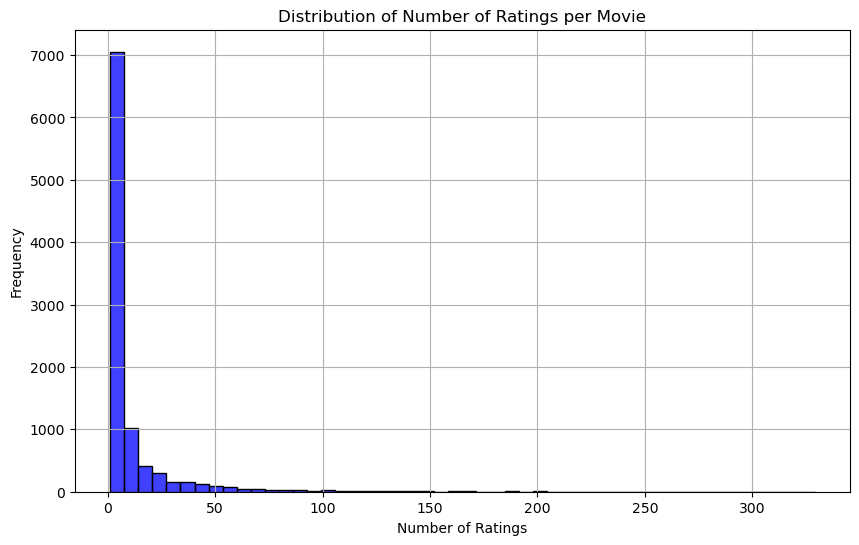

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(x = ratings_new['num_of_ratings'], bins=50, kde=False, color='blue')
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The distribution of the number of ratings per movie is rightly skewed. This implies that majority of the movies have less than 50 ratings with a few having above 100 ratings for a single movie. 50% of the movies have fewer than 50 ratings.

In [18]:
# ratings_new['num_of_ratings'].value_counts(normalize = True)

#### 5.1.2 - Distribution of Ratings

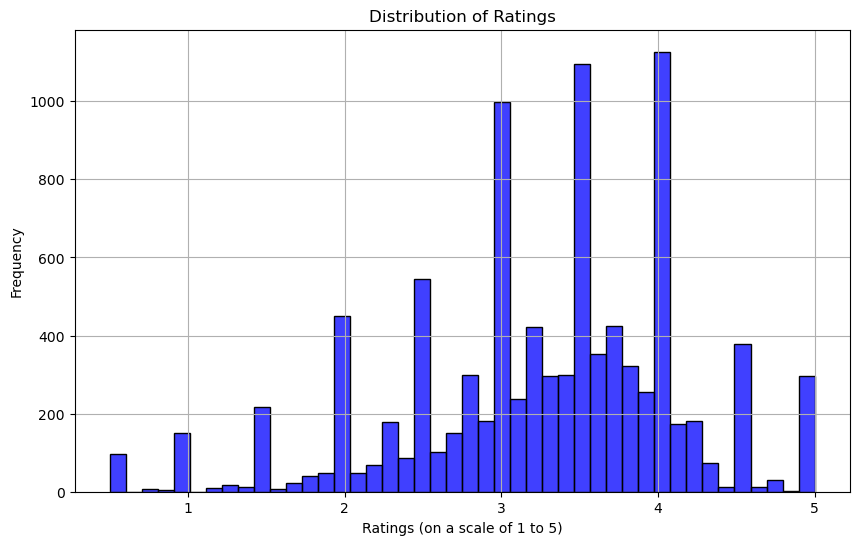

In [19]:
plt.figure(figsize=(10,6))
sns.histplot(x = ratings_new['rating'],  kde=False, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings (on a scale of 1 to 5)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [20]:
# binning 
bins = [0, 1, 2, 3, 4, 5]
ratings_new['rating_binned'] = pd.cut(ratings_new['rating'], bins=bins,  right=True)


In [21]:
ratings_new['rating_binned'].value_counts(normalize = True).sort_values()

rating_binned
(0, 1]    0.026532
(1, 2]    0.084430
(4, 5]    0.129576
(2, 3]    0.266968
(3, 4]    0.492493
Name: proportion, dtype: float64

Around 49% of movies receive ratings between 3 and 4. This implies that most movies receive above average ratings and fewer movies receive extremely low or high ratings.

### 5.2 Bivariate Analysis

#### 5.1.2 -  Number of Ratings per User

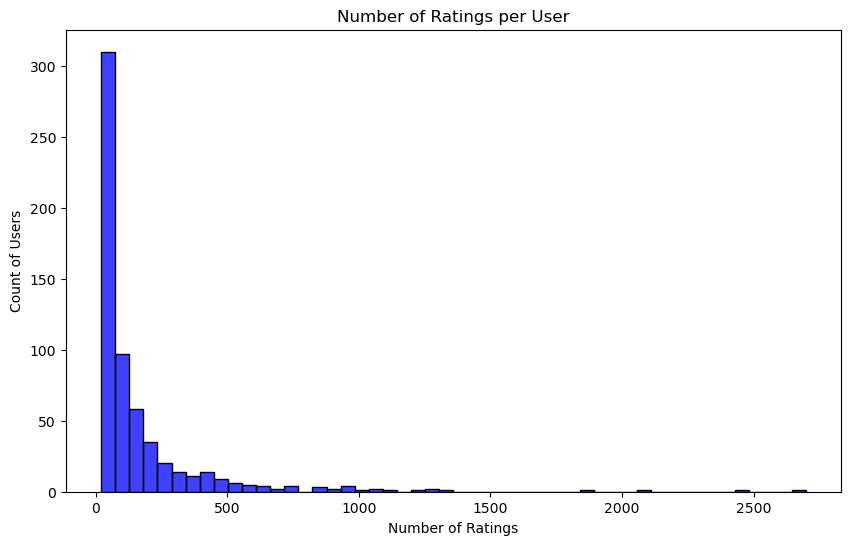

In [22]:
# calculate number of ratings per user
# Number of ratings per user
user_ratings_count = movies_and_ratings.groupby('userId').size()

plt.figure(figsize=(10, 6))
sns.histplot(user_ratings_count, bins=50, kde=False, color = 'blue')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()

#### 5.1.2 - Most Popular Movies

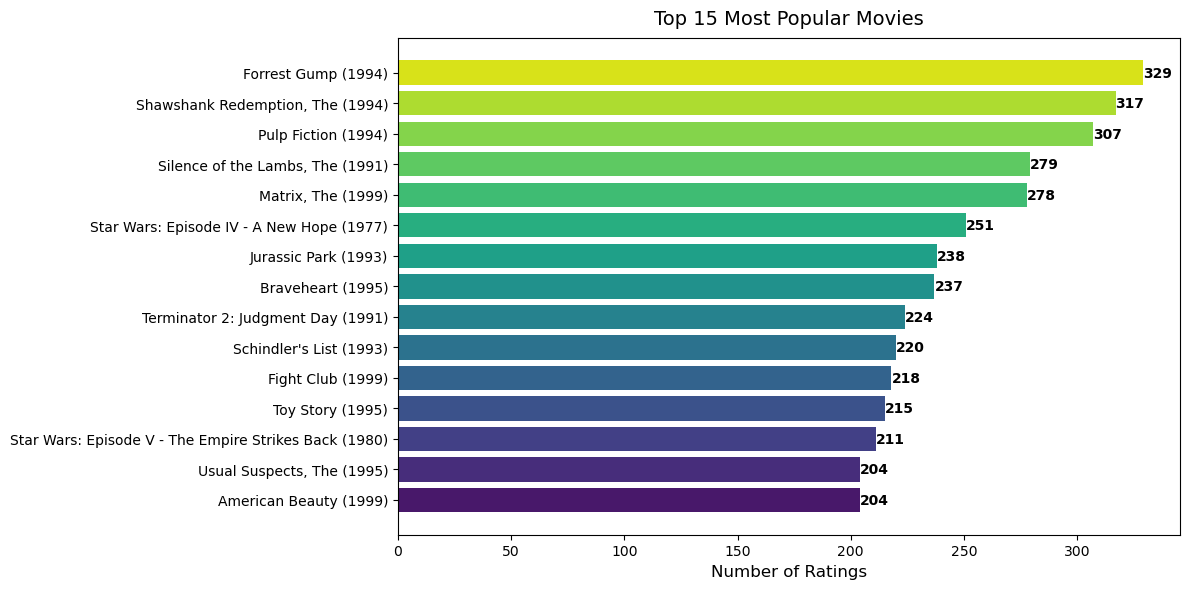


Top 15 Most Rated Movies:
                                                title  number_of_ratings
                               American Beauty (1999)                204
                           Usual Suspects, The (1995)                204
Star Wars: Episode V - The Empire Strikes Back (1980)                211
                                     Toy Story (1995)                215
                                    Fight Club (1999)                218
                              Schindler's List (1993)                220
                    Terminator 2: Judgment Day (1991)                224
                                    Braveheart (1995)                237
                                 Jurassic Park (1993)                238
            Star Wars: Episode IV - A New Hope (1977)                251
                                   Matrix, The (1999)                278
                     Silence of the Lambs, The (1991)                279
                        

In [23]:
# Group by movie title and count the number of ratings
movie_ratings_count = movies_and_ratings.groupby('title')['rating'].count().reset_index()
movie_ratings_count.columns = ['title', 'number_of_ratings']

# Sort by number of ratings and get top 15
top_rated_movies = movie_ratings_count.sort_values('number_of_ratings').tail(15)

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.barh(y=range(len(top_rated_movies)), width=top_rated_movies['number_of_ratings'],
                color=sns.color_palette("viridis", len(top_rated_movies)))

# Customize the plot
plt.yticks(range(len(top_rated_movies)), top_rated_movies['title'], fontsize=10)
plt.xlabel('Number of Ratings', fontsize=12)
plt.title('Top 15 Most Popular Movies', fontsize=14, pad=10)

# Add number of ratings to the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:,.0f}',  # Format number with commas
             va='center', ha='left', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print the data
print("\nTop 15 Most Rated Movies:")
print(top_rated_movies.to_string(index=False))

#### 5.1.2 - Top 15 Movies by Average Ratings

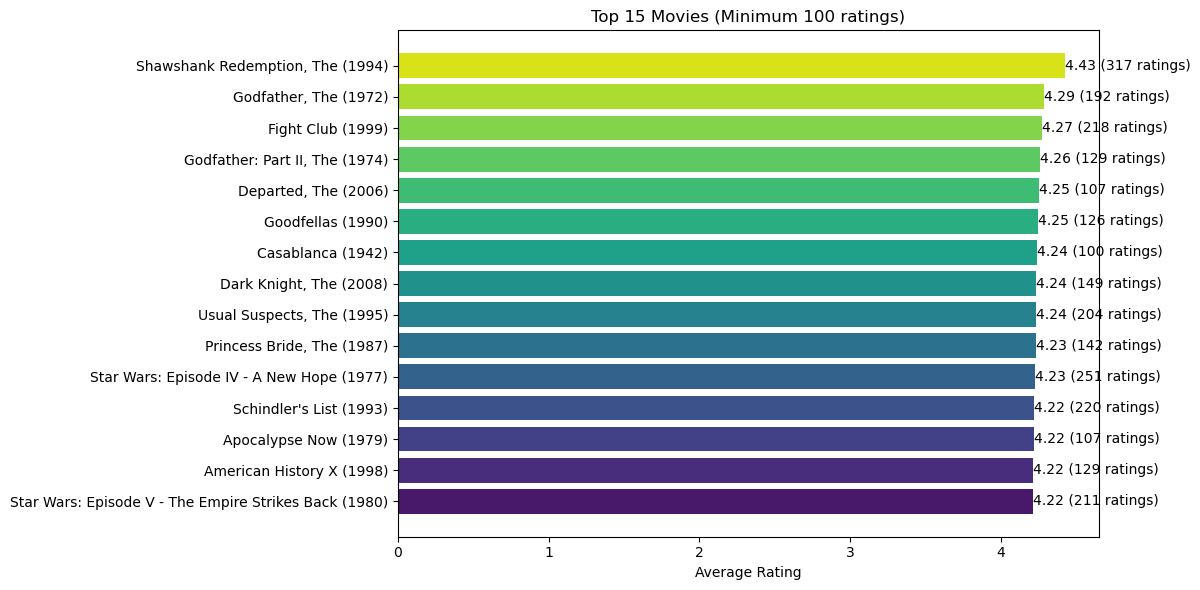


Top 15 Movies Data:
                                                title  avg_rating  num_ratings
Star Wars: Episode V - The Empire Strikes Back (1980)    4.215640          211
                            American History X (1998)    4.217054          129
                                Apocalypse Now (1979)    4.219626          107
                              Schindler's List (1993)    4.225000          220
            Star Wars: Episode IV - A New Hope (1977)    4.231076          251
                           Princess Bride, The (1987)    4.232394          142
                           Usual Suspects, The (1995)    4.237745          204
                              Dark Knight, The (2008)    4.238255          149
                                    Casablanca (1942)    4.240000          100
                                    Goodfellas (1990)    4.250000          126
                                 Departed, The (2006)    4.252336          107
                       Godfathe

In [24]:
# Calculate average rating for each movie and number of ratings
movie_stats = movies_and_ratings.groupby('title').agg({
    'rating': ['mean', 'count']
}).reset_index()

# Flatten the column names
movie_stats.columns = ['title', 'avg_rating', 'num_ratings']

# Filter for movies with a minimum number of ratings
min_ratings = 100 
popular_movies = movie_stats[movie_stats['num_ratings'] >= min_ratings]

# Sort by average rating and get top 10
top_movies = popular_movies.sort_values('avg_rating').tail(15)

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.barh(y=range(len(top_movies)), width=top_movies['avg_rating'], 
                color=sns.color_palette("viridis", len(top_movies)))

# Customize the plot
plt.yticks(range(len(top_movies)), top_movies['title'])
plt.xlabel('Average Rating')
plt.title(f'Top 15 Movies (Minimum {min_ratings} ratings)')

# Add rating annotations to the end of each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{top_movies["avg_rating"].iloc[i]:.2f} ({top_movies["num_ratings"].iloc[i]} ratings)',
             va='center', ha='left')

plt.tight_layout()
plt.show()

# Print the data
print("\nTop 15 Movies Data:")
print(top_movies[['title', 'avg_rating', 'num_ratings']].to_string(index=False))

### 5.3 Multivariate Analysis

## 6. Data Preparation for Modelling



In [25]:
# prepare data for 
reader = Reader(rating_scale = (0.5, 5.0))
data = Dataset.load_from_df(movies_and_ratings[['userId', 'movieId', 'rating']], reader)

# split data into train and test sets

train_set, test_set = train_test_split(data, test_size = 0.2)

## 7. Data Modelling

We are going to explore different modelling approaches: 
1. `KNNBasic` model and experiment with the different similarity metrics (cosine, pearson).
2. `KMWithMeans` which takes into account the mean rating of each user.
3. `KNNBaseline` which adds adds in a bias term that is calculated by way of minimizing a cost function.
4. model based CF with SVD
5. Hyperparameter tuning on the SVD model


### 7.1 Baseline Model

Before we begin, it is important to decide which type of collaborative filtering to consider. Here, we use user-user filtering as it is the lesser of the two. This is in order to reduce computation time

In [26]:
# deciding whether to use item-item Vs user-user similarity. Use whichever is fewer. In this case, users
print("Number of users: ", train_set.n_users, "\n")
print("Number of items: ", train_set.n_items, "\n")

Number of users:  610 

Number of items:  8953 



In [27]:
# define similarity metric to use 
similarity_cos = {"name": "cosine", "user_based": True}

# baseline model
baseline_model =KNNBasic(sim_options = similarity_cos)

# fit the model
baseline_model.fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [28]:
# cross validation on baseline model
cv_baseline_model = cross_validate(baseline_model, data, n_jobs=-1)

# Get the average RMSE score across all folds
average_rmse = cv_baseline_model['test_rmse'].mean()
print(f"The average rmse score is {average_rmse}")

# make predictions
# baseline_predictions = baseline_model.test(test_set)

The average rmse score is 0.9742858669095578


This implies that the model is off by about 0.9723 points for each guess it made for ratings. While it is not bad, there is room for improvement as we are working with a small scale (1 to 5)

### 7.2 Model 2 - Pearson Similarity Metric

In [29]:
similarity_pearson = {"name": "pearson", "user_based" : True}

# fit model
model_pearson = KNNBasic(sim_options = similarity_pearson)

model_pearson.fit(train_set)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [30]:
cv_model_pearson = cross_validate(model_pearson, data, n_jobs=-1)

# get average rmse

avg_rmse_pearson = cv_model_pearson['test_rmse'].mean()

# print rmse
print(f"Average rmse score is : {avg_rmse_pearson}")
# model_pearson_predictions = model_pearson.test(test_set)

Average rmse score is : 0.9744300409373352


The rmse score is 0.9739. This implies that the model's predictions are off by about 0.9939 points. This is a very slight decline from the baseline model. They have about the same performance.

### 7.3 Model 3 - KNNMeans

In [31]:
model_knn_means  = KNNWithMeans(sim_options = similarity_cos)

# fit model
model_knn_means.fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [32]:
# cross validate the model
cv_model_knn_means = cross_validate(model_knn_means, data, n_jobs=-1)

avg_rmse_model_knn_means = cv_model_knn_means['test_rmse'].mean()

print(f"The average rmse is : {avg_rmse_model_knn_means}")

The average rmse is : 0.8997396309763065


This model has an rmse score of 0.90 This is better then the two models before. However, there's room for improvement and so we proceed to using KNNBaseline as it introduces a bias term making it an improvement of the methods explored above.

### 7.4 Model 4 - KNNBaseline

In [33]:
model_knn_baseline = KNNBaseline(sim_options=similarity_cos)

# fit model
model_knn_baseline.fit(train_set)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [34]:
# rmse
cv_model_knn_baseline = cross_validate(model_knn_baseline, data, n_jobs = -1)

avg_rmse_knn_baseline = cv_model_knn_baseline['test_rmse'].mean()

print(f"The average rmse is : {avg_rmse_knn_baseline}")

The average rmse is : 0.8789893602498878


The rmse score for the `KNNBaseline` model is 0.879. This is an improvement from the previous models above. We are looking to further reduce this error, therefore, we try matrix factorization models below. In this case, we use Singular Value Decomposition(SVD) and tune the hyperparameters to get the optimal parameters.

### 7.5 Model 5 - Model based

In [35]:
# use SVD for collaborative filtering
model = SVD()
model.fit(train_set)

In [36]:
# Evaluate the model
cv_model = cross_validate(model, data, n_jobs = -1)

avg_rmse_model = cv_model['test_rmse'].mean()

print(f"The average rmse is : {avg_rmse_model}")

The average rmse is : 0.872704323882072


This model's rmse score is 0.873. This is a slight improvement from the `KNNBaseline` model. They however seem to be performing similarly.

### 7.6 Model 6 - Hyperparameter Tuning

In [37]:
param_grid= {'n_factors': [50, 100, 150],
         'reg_all': [0.02, 0.05, 0.1]}

gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1, cv = 5, joblib_verbose=5)
gs_model.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   42.2s finished


In [38]:
gs_model.best_score['rmse']

0.8693005749407966

In [39]:
# Extract the best model from GridSearchCV
best_model = gs_model.best_estimator['rmse']

In [40]:
# fit on model
best_model.fit(train_set)

The model's rmse score is 0.869. This implies that the model's predictions are off by about 0.869 points. This is a slight improvement from the previous models and overally the best.

## 8. Model Evaluation

In [41]:
final_model = best_model

# test final model ofn test set
final_model_predictions = final_model.test(test_set)

# rmse score for final model. get rmse from test set
rmse_final = accuracy.rmse(final_model_predictions)




RMSE: 0.8627


## 9. Conclusions

## 10. Recommendations